# Karim Kuserbaev

## Funcs

In [3]:
def get_df_low(code: int):
    train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df



def get_feature_description():
  feature_description = pd.read_excel("../data/feature_description.xlsx") # import feature_description to merge description
  feature_description.columns =  ['col_name', 'description', 'type']
  return feature_description



def cat_column_summary(df):
    """Для категорий всех столбцов"""
    df = df.select_dtypes(exclude="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })


    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd

def num_column_summary(df):
    """Для численных всех столбцов"""

    df = df.select_dtypes(include="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        mean = df[col_name].mean()
        std = df[col_name].std()
        min_val = df[col_name].min()
        q25 = df[col_name].quantile(0.25)
        q50 = df[col_name].quantile(0.50)
        q75 = df[col_name].quantile(0.75)
        max_val = df[col_name].max()


        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
            'distinct_values_counts': distinct_values_counts

        })




    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd
# Пустые значения


def get_nan_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])

  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: x.isna().all()).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', suffixes=('_left', '_right'), how='left')
    end_time = time.time()
  return nan_3_month_df



def process_nan(x):
    try:
        x = x.dropna(
        ).values[-1] if x.isna().any() and not x.isna().all() else np.nan
        return x
    except:
        print(x)
        return x




def get_nan_values_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])
  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: process_nan(x)).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', how='left')
    end_time = time.time()
    print(f"{column} {end_time - start_time}")
  return nan_3_month_df



def plt_null_df(df):

    plt.figure(figsize=(15, 8))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()




# Корреляция
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()

  plt.figure(figsize=(20, 15))
  dataplot = sns.heatmap(corr_df,
                        cmap="YlGnBu", annot=True, fmt=".1f",
                        annot_kws={'size': 5})
  plt.show()

def get_columns_corr(df, p: int):
    corr_df = df.select_dtypes(include='number').corr().abs()
    c1 = corr_df.unstack()

    c1_sorted = c1.sort_values(ascending=True)
    columns_above = {(col1, col2): c1_sorted[col1, col2] for col1, col2 in c1_sorted.index if c1_sorted[col1, col2] > p and col1 != col2}

    return dict(sorted(columns_above.items(), key=lambda item: item[1], reverse=True))

## Импорт библиотек и настройки

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
!pip install catboost

In [67]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import catboost
from catboost import *
from catboost import datasets


import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings

# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Ваш код, вызывающий предупреждение о переполнении

# Включить предупреждения обратно
# warnings.filterwarnings("default")

In [68]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.13.2
lightgbm==4.1.0
numpy==1.25.2
pandas==2.0.3
pandas-datareader==0.10.0
pandas-gbq==0.19.2
pandas-stubs==2.0.3.230814
scikit-learn==1.2.2
sklearn-pandas==2.2.0


In [69]:
pd.options.display.max_rows = 93
pd.options.display.max_columns = 93

## Загрузка данных

In [247]:
df = pd.read_parquet("/content/drive/MyDrive/Alfa-hak/df_afte_fe.pqt")


cat_cols = [
          "channel_code", "city", "city_type",
          "okved", "segment", "start_cluster", "ogrn_month", "ogrn_year",
      ]


df[cat_cols] = df[cat_cols].astype("object")


df['date'] = df['date'].replace({'month_4': 'month_1', 'month_5': 'month_2', 'month_6': 'month_3'})

In [188]:
df['date'].value_counts()

date
month_2    197440
month_3    197440
month_1    187560
Name: count, dtype: int64

## Анализ

In [130]:
train_df = df[df['id']< 200000]
test_df = df[df['id'] >= 200000]

Размерность

In [131]:
df.shape

(582440, 41)

In [132]:
train_df.shape, test_df.shape

((292320, 41), (290120, 41))

In [133]:
test_df[['id', 'date']]

,id,date
600000,200000,month_1
600001,200000,month_2
600002,200000,month_3
600003,200001,month_1
600004,200001,month_2
...,...,...
890115,299998,month_2
890116,299998,month_3
890117,299999,month_1
890118,299999,month_2


Количество строк без пропусков

In [76]:
train_df.dropna().shape

(268615, 41)

In [77]:
test_df.dropna().shape

(0, 41)

## Предобработка

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 582440 entries, 0 to 890119
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     582440 non-null  int64  
 1   date                   582440 non-null  object 
 2   balance_amt_min        552701 non-null  float64
 3   channel_code           568702 non-null  object 
 4   city                   517768 non-null  object 
 5   city_type              517432 non-null  object 
 6   ogrn_days_end_month    568156 non-null  float64
 7   ogrn_days_end_quarter  568156 non-null  float64
 8   ogrn_month             582130 non-null  object 
 9   ogrn_year              582130 non-null  object 
 10  ogrn_exist_months      568156 non-null  float64
 11  okved                  581844 non-null  object 
 12  segment                582420 non-null  object 
 13  sum_a_oper_1m          582440 non-null  float64
 14  sum_b_oper_1m          582440 non-null  f

In [249]:
df

,id,date,balance_amt_min,channel_code,city,city_type,ogrn_days_end_month,ogrn_days_end_quarter,ogrn_month,ogrn_year,ogrn_exist_months,okved,segment,sum_a_oper_1m,sum_b_oper_1m,sum_c_oper_1m,sum_deb_d_oper_1m,sum_cred_d_oper_1m,sum_deb_e_oper_1m,sum_cred_e_oper_1m,sum_deb_f_oper_1m,sum_cred_f_oper_1m,sum_deb_g_oper_1m,sum_cred_g_oper_1m,sum_deb_h_oper_1m,sum_cred_h_oper_1m,sum_a_oper_3m,sum_b_oper_3m,sum_c_oper_3m,sum_deb_d_oper_3m,sum_cred_d_oper_3m,sum_deb_e_oper_3m,sum_cred_e_oper_3m,sum_deb_f_oper_3m,sum_cred_f_oper_3m,sum_deb_g_oper_3m,sum_cred_g_oper_3m,sum_deb_h_oper_3m,sum_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,-0.0606,channel_code_5,city_23,city_type_0,-0.4886,-0.1351,ogrn_month_0,ogrn_year_1,2.3249,okved_30,segment_1,-0.1888,-0.0302,-0.1034,-0.1285,-0.0637,0.1302,0.1188,-0.1252,-0.0180,-0.0414,-0.0298,-0.0140,0.0642,-0.2071,-0.0300,-0.1197,-0.1432,-0.0847,0.1593,0.1550,-0.1521,-0.0256,-0.0406,-0.0243,0.0261,0.1325,"{α, γ}",{other}
1,0,month_2,-0.0606,channel_code_5,city_23,city_type_0,-0.4886,-0.1351,ogrn_month_0,ogrn_year_1,2.3249,okved_30,segment_1,-0.1888,-0.0302,-0.1034,-0.0882,-0.0637,0.1302,0.0951,-0.1018,-0.0180,-0.0414,-0.0298,-0.0140,0.0642,-0.2071,-0.0300,-0.1197,-0.1278,-0.0847,0.1593,0.1550,-0.1422,-0.0256,-0.0406,-0.0243,0.0261,0.1325,"{α, γ}",{other}
2,0,month_3,-0.0606,channel_code_5,city_23,city_type_0,-0.4886,-0.1351,ogrn_month_0,ogrn_year_1,2.3249,okved_30,segment_1,-0.1888,-0.0302,-0.1034,-0.1285,-0.0637,0.1302,0.1188,-0.1252,-0.0180,-0.0414,-0.0298,-0.0140,0.0642,-0.2071,-0.0300,-0.1197,-0.1278,-0.0847,0.1593,0.1550,-0.1422,-0.0256,-0.0406,-0.0243,0.0261,0.1325,"{α, γ}",{other}
3,1,month_1,-0.1140,channel_code_2,city_14,city_type_0,0.3243,1.2587,ogrn_month_5,ogrn_year_15,0.1765,okved_5,segment_1,-0.1888,-0.0302,-0.1034,-0.0618,-0.0637,0.0971,0.1132,-0.1642,-0.0180,-0.0212,-0.0298,-0.0140,-0.1710,-0.2071,-0.0300,-0.1197,-0.0164,-0.0847,0.1593,0.1550,-0.1994,-0.0256,-0.0088,-0.0246,0.0261,-0.1840,{other},{other}
4,1,month_2,-0.1193,channel_code_2,city_14,city_type_0,0.3243,1.2587,ogrn_month_5,ogrn_year_15,0.1939,okved_5,segment_1,-0.1888,-0.0302,-0.1034,-0.0618,-0.0637,-0.0113,-0.0359,-0.1630,-0.0180,-0.0212,-0.0298,-0.0183,-0.1307,-0.2071,-0.0300,-0.1197,-0.0164,-0.0847,0.0685,0.0595,-0.1949,-0.0256,-0.0088,-0.0243,0.0261,-0.1839,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_2,NaN,channel_code_9,city_25,city_type_0,NaN,NaN,ogrn_month_8,ogrn_year_11,NaN,okved_17,segment_2,-0.1888,-0.0302,-0.1034,-0.1285,-0.0637,-0.1428,-0.1439,-0.1736,-0.0180,-0.0414,-0.0298,-0.1589,-0.1718,-0.2071,-0.0300,-0.1197,-0.1432,-0.0847,-0.1530,-0.1565,-0.2135,-0.0256,-0.0406,-0.0286,-0.1656,-0.2011,{},None
890116,299998,month_3,-0.1260,channel_code_9,city_25,city_type_0,0.6727,-0.9481,ogrn_month_8,ogrn_year_11,-0.6063,okved_17,segment_2,-0.1888,-0.0302,-0.1034,-0.1285,-0.0637,-0.1428,-0.1433,-0.1736,-0.0180,-0.0414,-0.0298,-0.1589,-0.1718,-0.2071,-0.0300,-0.1197,-0.1432,-0.0847,-0.1530,-0.1563,-0.2135,-0.0256,-0.0406,-0.0286,-0.1656,-0.2011,{},None
890117,299999,month_1,-0.1260,channel_code_9,city_6,city_type_0,-1.1853,-0.4061,ogrn_month_11,ogrn_year_14,-0.4845,okved_17,segment_3,-0.1888,-0.0302,-0.1034,-0.1285,-0.0637,-0.0527,-0.0450,-0.1736,-0.0180,-0.0414,-0.0298,-0.0140,0.0642,-0.2071,-0.0300,-0.1197,-0.1432,-0.0847,-0.1199,-0.1198,-0.2135,-0.0256,-0.0406,-0.0286,-0.0976,-0.1014,{α},None
890118,299999,month_2,-0.1215,channel_code_9,city_6,city_type_0,-1.1853,-0.4061,ogrn_month_11,ogrn_year_14,-0.4671,okved_17,segment_3,-0.1888,-0.0302,-0.1034,-0.1285,-0.0637,-0.0551,-0.0560,-0.1736,-0.0180,-0.0212,-0.0298,-0.0140,0.0559,-0.2071,-0.0300,-0.1197,-0.1432,-0.0847,-0.0922,-0.0954,-0.2135,-0.0256,-0.0338,-0.0286,-0.0479,-0.0349,{α},None


In [250]:
pivot_df = df.pivot_table(index='id', columns='date', aggfunc='first')

# Преобразуем мультииндексные столбцы в одноуровневые
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

# Объединяем строки для каждого клиента в одну
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(columns = ['end_cluster_month_1', 'end_cluster_month_2'] , axis = 0)

In [251]:
pivot_df

,id,balance_amt_min_month_1,balance_amt_min_month_2,balance_amt_min_month_3,channel_code_month_1,channel_code_month_2,channel_code_month_3,city_month_1,city_month_2,city_month_3,city_type_month_1,city_type_month_2,city_type_month_3,end_cluster_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_exist_months_month_1,ogrn_exist_months_month_2,ogrn_exist_months_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_a_oper_1m_month_1,sum_a_oper_1m_month_2,sum_a_oper_1m_month_3,sum_a_oper_3m_month_1,sum_a_oper_3m_month_2,sum_a_oper_3m_month_3,sum_b_oper_1m_month_1,sum_b_oper_1m_month_2,...,sum_cred_f_oper_1m_month_3,sum_cred_f_oper_3m_month_1,sum_cred_f_oper_3m_month_2,sum_cred_f_oper_3m_month_3,sum_cred_g_oper_1m_month_1,sum_cred_g_oper_1m_month_2,sum_cred_g_oper_1m_month_3,sum_cred_g_oper_3m_month_1,sum_cred_g_oper_3m_month_2,sum_cred_g_oper_3m_month_3,sum_cred_h_oper_1m_month_1,sum_cred_h_oper_1m_month_2,sum_cred_h_oper_1m_month_3,sum_cred_h_oper_3m_month_1,sum_cred_h_oper_3m_month_2,sum_cred_h_oper_3m_month_3,sum_deb_d_oper_1m_month_1,sum_deb_d_oper_1m_month_2,sum_deb_d_oper_1m_month_3,sum_deb_d_oper_3m_month_1,sum_deb_d_oper_3m_month_2,sum_deb_d_oper_3m_month_3,sum_deb_e_oper_1m_month_1,sum_deb_e_oper_1m_month_2,sum_deb_e_oper_1m_month_3,sum_deb_e_oper_3m_month_1,sum_deb_e_oper_3m_month_2,sum_deb_e_oper_3m_month_3,sum_deb_f_oper_1m_month_1,sum_deb_f_oper_1m_month_2,sum_deb_f_oper_1m_month_3,sum_deb_f_oper_3m_month_1,sum_deb_f_oper_3m_month_2,sum_deb_f_oper_3m_month_3,sum_deb_g_oper_1m_month_1,sum_deb_g_oper_1m_month_2,sum_deb_g_oper_1m_month_3,sum_deb_g_oper_3m_month_1,sum_deb_g_oper_3m_month_2,sum_deb_g_oper_3m_month_3,sum_deb_h_oper_1m_month_1,sum_deb_h_oper_1m_month_2,sum_deb_h_oper_1m_month_3,sum_deb_h_oper_3m_month_1,sum_deb_h_oper_3m_month_2,sum_deb_h_oper_3m_month_3
0,0,-0.0606,-0.0606,-0.0606,channel_code_5,channel_code_5,channel_code_5,city_23,city_23,city_23,city_type_0,city_type_0,city_type_0,{other},-0.4886,-0.4886,-0.4886,-0.1351,-0.1351,-0.1351,2.3249,2.3249,2.3249,ogrn_month_0,ogrn_month_0,ogrn_month_0,ogrn_year_1,ogrn_year_1,ogrn_year_1,okved_30,okved_30,okved_30,segment_1,segment_1,segment_1,"{α, γ}","{α, γ}","{α, γ}",-0.1888,-0.1888,-0.1888,-0.2071,-0.2071,-0.2071,-0.0302,-0.0302,...,-0.0180,-0.0256,-0.0256,-0.0256,-0.0298,-0.0298,-0.0298,-0.0243,-0.0243,-0.0243,0.0642,0.0642,0.0642,0.1325,0.1325,0.1325,-0.1285,-0.0882,-0.1285,-0.1432,-0.1278,-0.1278,0.1302,0.1302,0.1302,0.1593,0.1593,0.1593,-0.1252,-0.1018,-0.1252,-0.1521,-0.1422,-0.1422,-0.0414,-0.0414,-0.0414,-0.0406,-0.0406,-0.0406,-0.0140,-0.0140,-0.0140,0.0261,0.0261,0.0261
1,1,-0.1140,-0.1193,-0.1141,channel_code_2,channel_code_2,channel_code_2,city_14,city_14,city_14,city_type_0,city_type_0,city_type_0,{other},0.3243,0.3243,0.3243,1.2587,1.2587,1.2587,0.1765,0.1939,0.2113,ogrn_month_5,ogrn_month_5,ogrn_month_5,ogrn_year_15,ogrn_year_15,ogrn_year_15,okved_5,okved_5,okved_5,segment_1,segment_1,segment_1,{other},{other},{other},-0.1888,-0.1888,-0.1888,-0.2071,-0.2071,-0.2071,-0.0302,-0.0302,...,-0.0180,-0.0256,-0.0256,-0.0256,-0.0298,-0.0298,-0.0298,-0.0246,-0.0243,-0.0243,-0.1710,-0.1307,-0.1159,-0.1840,-0.1839,-0.1679,-0.0618,-0.0618,-0.0618,-0.0164,-0.0164,-0.0164,0.0971,-0.0113,0.0052,0.1593,0.0685,0.0281,-0.1642,-0.1630,-0.1373,-0.1994,-0.1949,-0.1897,-0.0212,-0.0212,-0.0212,-0.0088,-0.0088,-0.0088,-0.0140,-0.0183,-0.0140,0.0261,0.0261,0.0261
2,2,-0.1228,-0.1228,-0.1124,channel_code_12,channel_code_12,channel_code_12,city_613,city_613,city_613,city_type_306,city_type_306,city_type_306,{α},-0.2563,-0.2563,-0.2563,-1.2579,-1.2579,-1.2579,0.2809,0.2983,0.3157,ogrn_month_9,ogrn_month_9,ogrn_month_9,og

In [252]:
columns_to_drop = [
    'city_type_month_1', 'ogrn_year_month_2', 'sum_a_oper_1m_month_1', 'sum_a_oper_1m_month_2',
    'sum_a_oper_1m_month_3', 'sum_a_oper_3m_month_1', 'sum_a_oper_3m_month_2', 'sum_a_oper_3m_month_3',
    'sum_b_oper_1m_month_1', 'sum_b_oper_1m_month_2', 'sum_b_oper_1m_month_3', 'sum_b_oper_3m_month_1',
    'sum_b_oper_3m_month_2', 'sum_b_oper_3m_month_3', 'sum_c_oper_1m_month_1', 'sum_c_oper_1m_month_2',
    'sum_c_oper_1m_month_3', 'sum_c_oper_3m_month_1', 'sum_c_oper_3m_month_2', 'sum_c_oper_3m_month_3',
    'sum_cred_d_oper_1m_month_1', 'sum_cred_d_oper_1m_month_2', 'sum_cred_d_oper_1m_month_3',
    'sum_cred_d_oper_3m_month_1', 'sum_cred_d_oper_3m_month_2', 'sum_cred_d_oper_3m_month_3',
    'sum_cred_f_oper_1m_month_1', 'sum_cred_f_oper_1m_month_2', 'sum_cred_f_oper_1m_month_3',
    'sum_cred_f_oper_3m_month_1', 'sum_cred_f_oper_3m_month_2', 'sum_cred_f_oper_3m_month_3',
    'sum_cred_g_oper_1m_month_1', 'sum_cred_g_oper_1m_month_2', 'sum_cred_g_oper_1m_month_3'
]

pivot_df.drop(columns=columns_to_drop, inplace=True, axis = 1)

In [253]:
train_df = pivot_df[pivot_df['id']< 200000]
test_df = pivot_df[pivot_df['id'] >= 200000]

In [254]:
test_df

,id,balance_amt_min_month_1,balance_amt_min_month_2,balance_amt_min_month_3,channel_code_month_1,channel_code_month_2,channel_code_month_3,city_month_1,city_month_2,city_month_3,city_type_month_2,city_type_month_3,end_cluster_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_exist_months_month_1,ogrn_exist_months_month_2,ogrn_exist_months_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_cred_e_oper_1m_month_1,sum_cred_e_oper_1m_month_2,sum_cred_e_oper_1m_month_3,sum_cred_e_oper_3m_month_1,sum_cred_e_oper_3m_month_2,sum_cred_e_oper_3m_month_3,sum_cred_g_oper_3m_month_1,sum_cred_g_oper_3m_month_2,sum_cred_g_oper_3m_month_3,sum_cred_h_oper_1m_month_1,sum_cred_h_oper_1m_month_2,sum_cred_h_oper_1m_month_3,sum_cred_h_oper_3m_month_1,sum_cred_h_oper_3m_month_2,sum_cred_h_oper_3m_month_3,sum_deb_d_oper_1m_month_1,sum_deb_d_oper_1m_month_2,sum_deb_d_oper_1m_month_3,sum_deb_d_oper_3m_month_1,sum_deb_d_oper_3m_month_2,sum_deb_d_oper_3m_month_3,sum_deb_e_oper_1m_month_1,sum_deb_e_oper_1m_month_2,sum_deb_e_oper_1m_month_3,sum_deb_e_oper_3m_month_1,sum_deb_e_oper_3m_month_2,sum_deb_e_oper_3m_month_3,sum_deb_f_oper_1m_month_1,sum_deb_f_oper_1m_month_2,sum_deb_f_oper_1m_month_3,sum_deb_f_oper_3m_month_1,sum_deb_f_oper_3m_month_2,sum_deb_f_oper_3m_month_3,sum_deb_g_oper_1m_month_1,sum_deb_g_oper_1m_month_2,sum_deb_g_oper_1m_month_3,sum_deb_g_oper_3m_month_1,sum_deb_g_oper_3m_month_2,sum_deb_g_oper_3m_month_3,sum_deb_h_oper_1m_month_1,sum_deb_h_oper_1m_month_2,sum_deb_h_oper_1m_month_3,sum_deb_h_oper_3m_month_1,sum_deb_h_oper_3m_month_2,sum_deb_h_oper_3m_month_3
97440,200000,-0.1260,-0.1243,-0.1260,channel_code_12,channel_code_12,channel_code_12,city_14,city_14,city_14,city_type_0,city_type_0,None,-1.5337,-1.5337,-1.5337,-1.6837,-1.6837,-1.6837,-0.6585,-0.6411,-0.6237,ogrn_month_8,ogrn_month_8,ogrn_month_8,ogrn_year_11,ogrn_year_11,okved_0,okved_0,okved_0,segment_3,segment_3,segment_3,{α},{α},{α},0.1188,0.1188,0.0909,0.1434,0.1550,0.1550,-0.0243,-0.0243,-0.0243,0.0642,0.0642,0.0642,0.0317,0.1325,0.1325,-0.1285,-0.1285,-0.1285,-0.1432,-0.1432,-0.1432,0.1302,0.1197,-0.0020,0.1593,0.1593,0.1497,0.2529,0.2529,-0.1736,0.4050,0.4050,0.4050,-0.0346,-0.0212,-0.0212,-0.0088,-0.0088,-0.0136,-0.1441,-0.1455,-0.1502,-0.1540,-0.1505,-0.1528
97441,200001,-0.1259,-0.1259,-0.1259,channel_code_9,channel_code_9,channel_code_9,city_76,city_76,city_76,city_type_0,city_type_0,None,0.0921,0.0921,0.0921,1.2200,1.2200,1.2200,-0.6585,-0.6411,-0.6237,ogrn_month_10,ogrn_month_10,ogrn_month_10,ogrn_year_11,ogrn_year_11,okved_6,okved_6,okved_6,segment_3,segment_3,segment_3,{α},{α},{α},-0.1439,-0.1439,-0.1439,-0.1565,-0.1565,-0.1565,-0.0286,-0.0286,-0.0286,-0.1718,-0.1718,-0.1718,-0.2011,-0.2011,-0.2011,-0.1285,-0.1285,-0.1285,-0.1432,-0.1432,-0.1432,-0.1428,-0.1428,-0.1428,-0.1530,-0.1530,-0.1530,-0.1736,-0.1736,-0.1736,-0.2135,-0.2135,-0.2135,-0.0414,-0.0414,-0.0414,-0.0406,-0.0406,-0.0406,-0.1589,-0.1589,-0.1589,-0.1656,-0.1656,-0.1656
97442,200002,-0.1260,-0.1260,-0.1260,channel_code_12,channel_code_12,channel_code_12,city_14,city_14,city_14,city_type_0,city_type_0,None,-1.0692,-1.0692,-1.0692,-1.5289,-1.5289,-1.5289,-0.7629,-0.7455,-0.7281,ogrn_month_6,ogrn_month_6,ogrn_month_6,ogrn_year_11,ogrn_year_11,okved_63,okved_63,okved_63,segment_3,segment_3,segment_3,{other},{other},{other},0.1188,0.1188,0.1188,0.1550,0.1550,0.1550,-0.0243,-0.0243,-0.0243,0.0642,0.0642,0.0642,0.1325,0.1325,0.1325,-0.0618,-0.0618,-0.0618,-0.0164,-0.0164,-0.0164,0.1302,0.1302,0.1302,0.1593,0.1593,0.1593,0.2529,0.2318,0.2529,0.3990,0.4050,0.4050,-0.0212,-0.0212,-0.0212,-0.0088,-0.0088,-0.0088,-0.0140,-0.0140,-0.0140,0.0261,0.0261,0.0261
97443,200003,-0.1

Обозначение категориальных признаков

In [255]:
cat_names = [
    "channel_code", "city", "city_type", "ogrn_month", "ogrn_year",
    "okved", "segment", "start_cluster"
]



cat_names = list(pivot_df.select_dtypes(exclude= 'number').columns)


In [256]:
cat_names.remove("end_cluster_month_3")

In [257]:
cat_names

['channel_code_month_1',
 'channel_code_month_2',
 'channel_code_month_3',
 'city_month_1',
 'city_month_2',
 'city_month_3',
 'city_type_month_2',
 'city_type_month_3',
 'ogrn_month_month_1',
 'ogrn_month_month_2',
 'ogrn_month_month_3',
 'ogrn_year_month_1',
 'ogrn_year_month_3',
 'okved_month_1',
 'okved_month_2',
 'okved_month_3',
 'segment_month_1',
 'segment_month_2',
 'segment_month_3',
 'start_cluster_month_1',
 'start_cluster_month_2',
 'start_cluster_month_3']

In [258]:

label_encoders = {}

for col in cat_names:
    print(col)
    label_encoders[col] = LabelEncoder().fit(pivot_df[col])

    train_df[col] = label_encoders[col].transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

channel_code_month_1
channel_code_month_2
channel_code_month_3
city_month_1
city_month_2
city_month_3
city_type_month_2
city_type_month_3
ogrn_month_month_1
ogrn_month_month_2
ogrn_month_month_3
ogrn_year_month_1
ogrn_year_month_3
okved_month_1
okved_month_2
okved_month_3
segment_month_1
segment_month_2
segment_month_3
start_cluster_month_1
start_cluster_month_2
start_cluster_month_3


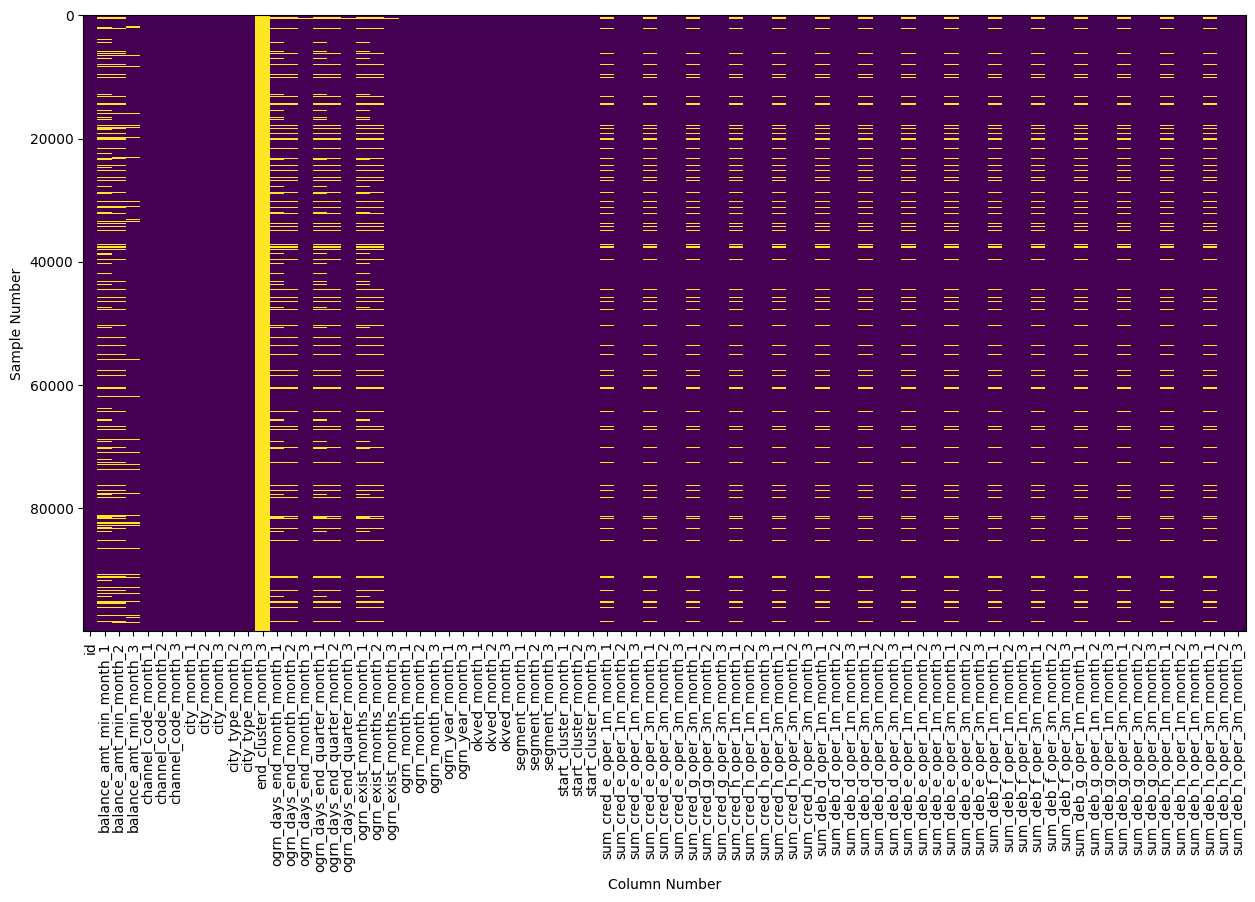

In [259]:
plt_null_df(test_df.isna())

### Создаем каждого клиента со всеми его признаками

### Создаем выборки для валидации и обучения

Деление на обучающую и тестовую, исправляем дизбаланс классов, если не требуется, пропустить эти блоки до следующего текста

In [125]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97440 entries, 0 to 97439
Columns: 118 entries, id to sum_deb_h_oper_3m_month_3
dtypes: float64(90), int64(25), object(3)
memory usage: 88.5+ MB


In [48]:
# X = train_df.drop(["id", "date"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
# y = train_df["end_cluster"]

# x_train, x_val, y_train, y_val = train_test_split(X, y,
#                                                   test_size=0.2,
#                                                   random_state=42)

In [260]:
X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster_month_3"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [261]:
y.value_counts()

end_cluster_month_3
{α}          52739
{other}      13260
{α, γ}        9527
{α, η}        9524
{α, β}        2987
{}            2637
{α, θ}        1676
{α, δ}        1460
{α, ε}        1417
{α, ψ}         617
{α, μ}         536
{α, ε, η}      457
{α, ε, θ}      300
{α, λ}         197
{α, ε, ψ}       92
{λ}             11
{α, π}           3
Name: count, dtype: int64

In [262]:
# Calculate current class proportions
class_proportions = x_train['end_cluster_month_3'].value_counts(normalize=True)

# Identify underrepresented classes
underrepresented_classes = class_proportions[class_proportions < 0.08].index

# Create an empty list to store additional rows
additional_rows = []

# Calculate the number of additional rows needed for each underrepresented class
for class_label in underrepresented_classes:
    current_proportion = class_proportions[class_label]
    desired_proportion = 0.08
    current_count = (x_train['end_cluster_month_3'] == class_label).sum()
    desired_count = int(desired_proportion * len(train_df))
    additional_count = desired_count - current_count

    if additional_count > 0:
        additional_samples = x_train[x_train['end_cluster_month_3'] == class_label].sample(n=additional_count, replace=True)
        additional_rows.append(additional_samples)

# Concatenate additional rows with the original dataframe
if additional_rows:
    x_train = pd.concat([x_train] + additional_rows, ignore_index=True)

# Verify the class proportions after balancing
print(x_train['end_cluster_month_3'].value_counts(normalize=True))


end_cluster_month_3
{α}         0.2492
{other}     0.0627
{α, θ}      0.0460
{α, π}      0.0460
{α, ε, ψ}   0.0460
{α, ε, η}   0.0460
{α, λ}      0.0460
{α, ε, θ}   0.0460
{α, ψ}      0.0460
{α, ε}      0.0460
{α, μ}      0.0460
{}          0.0460
{α, β}      0.0460
{α, δ}      0.0460
{λ}         0.0460
{α, γ}      0.0452
{α, η}      0.0446
Name: proportion, dtype: float64


In [263]:
y_train = x_train['end_cluster_month_3']
x_train = x_train.drop(['end_cluster_month_3'], axis=1)
x_val = x_val.drop(['end_cluster_month_3'], axis=1)

In [264]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((169345, 79), (169345,), (19488, 79), (19488,))

Деление на тестовую и обучающую выборку без дизбаланса

In [151]:
# X = train_df.drop(["id", "date", "end_cluster"], axis=1)
# y = train_df["end_cluster"]

# x_train, x_val, y_train, y_val = train_test_split(X, y,
#                                                   test_size=0.2,
#                                                   random_state=42)

## Обучение модели

Кросс-валидация для CatBoost (не нажимать если не разбираешься). Если не разбираешься, идти к следующему блоку текста

In [ ]:
from catboost import cv

params = {
    'loss_function': 'MultiClass',
    'iterations': 512,
    'random_seed': 43,
    'learning_rate': 0.1,
    'depth': 12,
    'task_type': 'GPU',
    'devices':'0'
}

cv_data = cv(
    params=params,
    pool=pool1,
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, # Никуда без визуализатора
    stratified=True,
    verbose=30
)

In [ ]:
cv_data

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

## Начало обучения

### CatBoostClassifier

model #13, classes balanced

In [273]:
model = CatBoostClassifier(iterations=2028,
                           depth=8,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                          )





In [274]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=15 # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_no_end_claster.json') # сохранение модели
    feature_importance = model.get_feature_importance(prettified=True) # датасет с важностью признаков

    return feature_importance

In [209]:
y_val

88248     {α, γ}
91812    {other}
35244     {α, η}
93852        {α}
51405        {α}
          ...   
1443         {α}
74493        {α}
86914        {α}
17662        {α}
52028        {α}
Name: end_cluster_month_3, Length: 19488, dtype: object

In [210]:
cat_names

['channel_code_month_1',
 'channel_code_month_2',
 'channel_code_month_3',
 'city_month_1',
 'city_month_2',
 'city_month_3',
 'city_type_month_1',
 'city_type_month_2',
 'city_type_month_3',
 'ogrn_month_month_1',
 'ogrn_month_month_2',
 'ogrn_month_month_3',
 'ogrn_year_month_1',
 'ogrn_year_month_2',
 'ogrn_year_month_3',
 'okved_month_1',
 'okved_month_2',
 'okved_month_3',
 'segment_month_1',
 'segment_month_2',
 'segment_month_3',
 'start_cluster_month_1',
 'start_cluster_month_2',
 'start_cluster_month_3']

In [275]:
feature_importance = train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.4768597	test: 2.4049816	best: 2.4049816 (0)	total: 106ms	remaining: 3m 34s
15:	learn: 1.5466358	test: 1.3987108	best: 1.3987108 (15)	total: 1.24s	remaining: 2m 35s
30:	learn: 1.3199301	test: 1.2204303	best: 1.2204303 (30)	total: 2.31s	remaining: 2m 28s
45:	learn: 1.1941078	test: 1.1541194	best: 1.1541194 (45)	total: 3.43s	remaining: 2m 27s
60:	learn: 1.1001111	test: 1.1210104	best: 1.1210104 (60)	total: 4.55s	remaining: 2m 26s
75:	learn: 1.0371127	test: 1.1004086	best: 1.1004086 (75)	total: 5.66s	remaining: 2m 25s
90:	learn: 0.9802444	test: 1.0848042	best: 1.0848042 (90)	total: 6.76s	remaining: 2m 23s
105:	learn: 0.9237196	test: 1.0682760	best: 1.0682760 (105)	total: 7.92s	remaining: 2m 23s
120:	learn: 0.8779735	test: 1.0555557	best: 1.0555557 (120)	total: 9.32s	remaining: 2m 26s
135:	learn: 0.8408284	test: 1.0445719	best: 1.0445719 (135)	total: 11.7s	remaining: 2m 43s
150:	learn: 0.8025801	test: 1.0331518	best: 1.0331518 (150)	total: 13.6s	remaining: 2m 49s
165:	learn: 0.7

In [277]:
feature_importance

,Feature Id,Importances
0,start_cluster_month_3,13.2535
1,start_cluster_month_1,4.0979
2,balance_amt_min_month_3,3.3608
3,city_month_1,3.2736
4,start_cluster_month_2,3.1837
5,balance_amt_min_month_1,2.7581
6,balance_amt_min_month_2,2.6316
7,ogrn_exist_months_month_1,2.5888
8,sum_deb_h_oper_3m_month_3,2.3844
9,okved_month_3,2.2969


Модель LGBM, блоки кода не нажимать чтобы не сбросилась model CatBoost. Я еще не тестил эту модель, переходи к метрикам

### LGBM

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

### Метрики

Зададим функцию для взвешенной метрики roc auc

In [278]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [279]:
cluster_weights = pd.read_excel("/content/drive/MyDrive/Alfa-hak/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [284]:
y_pred_proba.shape

(19488, 17)

In [180]:
y_val

88248     {α, γ}
91812    {other}
35244     {α, η}
93852        {α}
51405        {α}
          ...   
1443         {α}
74493        {α}
86914        {α}
17662        {α}
52028        {α}
Name: end_cluster_month_3, Length: 19488, dtype: object

In [283]:
y_pred_proba[0]

array([7.70927340e-02, 1.88724506e-02, 1.99220958e-03, 7.22241876e-01,
       7.57716723e-04, 7.64703941e-04, 3.06808709e-05, 7.38545582e-06,
       1.84553867e-03, 1.13415634e-03, 3.01123506e-03, 2.71271025e-04,
       8.44776847e-05, 6.91407034e-07, 7.32904959e-04, 1.71157680e-01,
       2.28761289e-06])

In [281]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## Прогноз на тестовой выборке

In [285]:
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Alfa-hak/sample_submission.csv") # поменять на свой
last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(["id", "date"], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = model.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_akm_3.csv", index=False) # сохранение модели

KeyError: 'date'

In [286]:
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Alfa-hak/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop("id", axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = model.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_akm_4.csv", index=False) # сохранение модели

In [185]:
sample_submission_df.shape # если (100000, 18), то все правильно. Если нет - надо писать Кариму и спрашивать(

(100000, 18)

In [186]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0080,0.0023,0.0008,0.0009,0.8542,0.0002,0.0029,0.0002,0.0008,0.0012,0.0042,0.0002,0.0014,0.0001,0.0008,0.1219,0.0000
1,200001,0.0115,0.0072,0.0005,0.0011,0.7917,0.0006,0.0017,0.0005,0.0038,0.0011,0.0012,0.0003,0.0035,0.0000,0.0020,0.1727,0.0006
2,200002,0.0213,0.0001,0.0003,0.0016,0.8951,0.0004,0.0063,0.0038,0.0018,0.0005,0.0017,0.0001,0.0016,0.0000,0.0030,0.0623,0.0000
3,200003,0.0089,0.0161,0.0004,0.0008,0.8310,0.0008,0.0021,0.0006,0.0035,0.0033,0.0012,0.0001,0.0010,0.0000,0.0007,0.1295,0.0001
4,200004,0.0123,0.0109,0.0024,0.0021,0.8983,0.0013,0.0025,0.0018,0.0031,0.0032,0.0017,0.0006,0.0019,0.0004,0.0021,0.0549,0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0070,0.0155,0.0009,0.0009,0.8266,0.0001,0.0008,0.0004,0.0026,0.0012,0.0009,0.0017,0.0012,0.0001,0.0012,0.1374,0.0014
99996,299996,0.0174,0.0055,0.0008,0.0011,0.5221,0.0003,0.0045,0.0001,0.0017,0.0007,0.0014,0.0006,0.0015,0.0000,0.0022,0.4378,0.0024
99997,299997,0.0085,0.0058,0.0005,0.0009,0.7337,0.0001,0.0056,0.0006,0.0014,0.0009,0.0009,0.0002,0.0034,0.0001,0.0124,0.2249,0.0001
99998,299998,0.0126,0.0226,0.0026,0.0044,0.7842,0.0022,0.0081,0.0055,0.0081,0.0062,0.0039,0.0012,0.0012,0.0008,0.0026,0.1312,0.0027


In [287]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0094,0.0324,0.0320,0.0169,0.0120,0.0000,0.0003,0.0000,0.0546,0.0029,0.0485,0.0002,0.0002,0.0000,0.0006,0.7901,0.0000
1,200001,0.0087,0.3294,0.0014,0.0060,0.0046,0.0001,0.0000,0.0000,0.0063,0.0063,0.0009,0.0007,0.0013,0.0000,0.0008,0.6334,0.0000
2,200002,0.4717,0.0017,0.0083,0.1187,0.0282,0.0004,0.0100,0.0058,0.1549,0.0045,0.0668,0.0025,0.0063,0.0000,0.0789,0.0412,0.0000
3,200003,0.0043,0.5038,0.0007,0.0019,0.0012,0.0002,0.0000,0.0000,0.0019,0.0134,0.0004,0.0001,0.0003,0.0000,0.0000,0.4718,0.0000
4,200004,0.1099,0.1479,0.0219,0.0101,0.0117,0.0027,0.0003,0.0028,0.0058,0.0736,0.0126,0.0004,0.0197,0.0003,0.0037,0.5753,0.0013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0034,0.1256,0.0012,0.0036,0.0020,0.0000,0.0000,0.0000,0.0143,0.0013,0.0007,0.0056,0.0001,0.0000,0.0004,0.8416,0.0000
99996,299996,0.0312,0.0910,0.0510,0.0458,0.0040,0.0001,0.0000,0.0000,0.0191,0.0032,0.0210,0.0008,0.0005,0.0000,0.0008,0.7314,0.0000
99997,299997,0.0241,0.2220,0.0345,0.0443,0.0139,0.0000,0.0004,0.0003,0.0154,0.0011,0.0076,0.0001,0.0002,0.0000,0.0535,0.5827,0.0000
99998,299998,0.0997,0.0932,0.0163,0.0093,0.0041,0.0007,0.0002,0.0054,0.0020,0.0347,0.0064,0.0008,0.0232,0.0003,0.0013,0.6998,0.0025
